# Introduction: Polynomial curve fitting


In [20]:
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(1)

Define noisy toy data for training. 

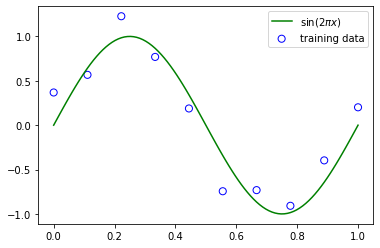

In [29]:
def create_toy_data(func, sample_size, std):
    x = np.linspace(0, 1, sample_size)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def func(x):
    return np.sin(2 * np.pi * x)
    # return np.exp(x)

x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.legend()
plt.show()



Define the transformation of the input data into feature space. Here, we use polynomials up to some maximal degree as features.

In [22]:
import itertools
import functools

class PolynomialFeature(object):
    """
    Example
    =======
    x =
    [[a1, a2],
    [b1, b2]]

    y = PolynomialFeatures(degree=2).transform(x)
    y =
    [[1, a1, a2, a1^2, a1 * a2, a2^2],
    [1, b1, b2, b1^2, b1 * b2, b2^2]]
    """

    def __init__(self, degree=2):
        assert isinstance(degree, int)
        self.degree = degree

    def transform(self, x):
        """
        transforms input array with polynomial features

        Parameters
        ----------
        x : (sample_size, n) ndarray
            input array

        Returns
        -------
        output : (sample_size, 1 + nC1 + ... + nCd) ndarray
            polynomial features
        """
        if x.ndim == 1:
            x = x[:, None]
        x_t = x.transpose()
        features = [np.ones(len(x))]
        for degree in range(1, self.degree + 1):
            for items in itertools.combinations_with_replacement(x_t, degree):
                features.append(functools.reduce(lambda x, y: x * y, items))
        return np.asarray(features).transpose()

Define the linear regression.

In [23]:
class LinearRegression(object):
    """
    Linear regression model
    y = X @ w 
    || y - X @ w ||^2 -> min_w
    """

    def fit(self, X, t):
        """
        perform least squares fitting

        Parameters
        ----------
        X : (N, D) np.ndarray
            transformed data, i.e. X = PolynomialFeature(degree).transform(x)
        t : (N,) np.ndarray
            training targets
        """
        self.w = np.linalg.pinv(X) @ t

    def predict(self, X):
        """
        make prediction given input

        Parameters
        ----------
        X : (N, D) np.ndarray
            (transformed) samples to predict their output

        Returns
        -------
        y : (N,) np.ndarray
            prediction of each sample
        """
        y = X @ self.w
        return y

Finally, we can fit the training data with our funtcion class.

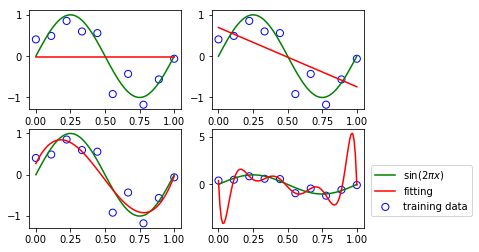

In [24]:
for i, degree in enumerate([0, 1, 3, 9]):
    plt.subplot(2, 2, i + 1)
    feature = PolynomialFeature(degree)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y = model.predict(X_test)

    plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
    plt.plot(x_test, y, c="r", label="fitting")
    # plt.ylim(-1.5, 1.5)
    plt.annotate("M={}".format(degree), xy=(-0.15, 1))
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
plt.show()

We notice a common problem in all sorts of learning methods: overfitting. For higher polynomial degrees (for example 9), we notice that the fitting curve interpolates the data perfectly, but the underlying function is completely misrepresented.

This effect gets more pronounced the more expressive our function space becomes.

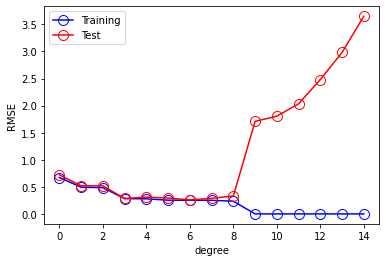

In [25]:

def rmse(a, b):
    return np.sqrt(np.mean(np.square(a - b)))

training_errors = []
test_errors = []

for i in range(15):
    feature = PolynomialFeature(i)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y = model.predict(X_test)
    training_errors.append(rmse(model.predict(X_train), y_train))
    test_errors.append(rmse(model.predict(X_test), y_test + np.random.normal(scale=0.25, size=len(y_test))))

plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("RMSE")
plt.show()



Overfitting can be reduced by introducing regularization. This is a form of prior knowledge, i.e. that the fitting curve should be "smooth" and not oscillate rapidly (as it does in the unregularized case for high polynomial degrees).

One way to do this is to penalize the 2-norm of the basis coefficients $w$.

In [26]:
class LinearRegressionRegularized(object):
    """
    Linear regression model
    || y - X @ w || + alpha*|| w ||_2^2 -> min_w
    """

    def __init__(self,alpha=.1):
        self.alpha = alpha

    def fit(self, X, t):
        """
        perform least squares fitting

        Parameters
        ----------
        X : (N, D) np.ndarray
            transformed data, i.e. X = PolynomialFeature(degree).transform(x)
        t : (N,) np.ndarray
            training targets
        """
        eye = np.eye(np.size(X, 1))
        self.w = np.linalg.solve(self.alpha * eye + X.T @ X, X.T @ t)

    def predict(self, X):
        """
        make prediction given input

        Parameters
        ----------
        X : (N, D) np.ndarray
            (transformed) samples to predict their output

        Returns
        -------
        y : (N,) np.ndarray
            prediction of each sample
        """
        y = X @ self.w
        return y


With suitable regularization in place, even complex function spaces can be used without overfitting.

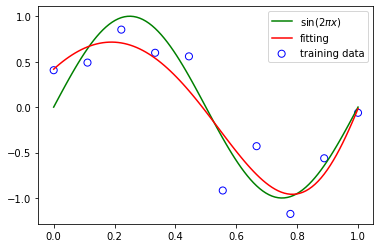

In [27]:


feature = PolynomialFeature(9)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = LinearRegressionRegularized(alpha=1e-3)
model.fit(X_train, y_train)
y = model.predict(X_test)

y = model.predict(X_test)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.plot(x_test, y, c="r", label="fitting")
# plt.ylim(-1.5, 1.5)
plt.legend()
plt.annotate("M=9", xy=(-0.15, 1))
plt.show()



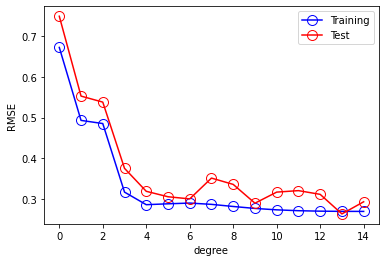

In [28]:
def rmse(a, b):
    return np.sqrt(np.mean(np.square(a - b)))

training_errors = []
test_errors = []

for i in range(15):
    feature = PolynomialFeature(i)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegressionRegularized(alpha=1e-3)
    model.fit(X_train, y_train)
    y = model.predict(X_test)
    training_errors.append(rmse(model.predict(X_train), y_train))
    test_errors.append(rmse(model.predict(X_test), y_test + np.random.normal(scale=0.25, size=len(y_test))))

plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("RMSE")
plt.show()
